In [ ]:
import tensorflow as tf
print("TF:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices("GPU"))


Matplotlib is building the font cache; this may take a moment.


TF: 2.19.0
GPUs: []


In [ ]:
import os, random, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import itertools


DATA_DIR = "/Users/poojan/brain_tumor_project/dataset/brain-mri-images-for-brain-tumor-detection"  

# Reproducibility
SEED = 42
tf.random.set_seed(SEED); np.random.seed(SEED); random.seed(SEED)

IMG_SIZE = (150, 150)
BATCH_SIZE = 32


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    color_mode="grayscale",      
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Normalize to [0,1] and prefetch
def norm(x, y): return (tf.cast(x, tf.float32) / 255.0, y)
train_ds = train_ds.map(norm).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(norm).prefetch(tf.data.AUTOTUNE)


Found 253 files belonging to 2 classes.
Using 203 files for training.
Found 253 files belonging to 2 classes.
Using 50 files for validation.
Classes: ['no', 'yes']


In [ ]:
def build_model():
    inputs = keras.Input(shape=(*IMG_SIZE, 1))  # (150,150,1)
    x = layers.Conv2D(32, (3,3), activation='relu', name="conv1")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', name="conv2")(x)  
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs, name="tumor_cnn")
    return model

model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc"), keras.metrics.Precision(name="prec"), keras.metrics.Recall(name="rec")],
)
model.summary()


Model: "tumor_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,327,361 (20.32 MB)

 Trainable params: 5,327,361 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, monitor="val_loss"),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
)


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6305 - auc: 0.6708 - loss: 0.6664 - prec: 0.6911 - rec: 0.6967 - val_accuracy: 0.7400 - val_auc: 0.8030 - val_loss: 0.5138 - val_prec: 0.7500 - val_rec: 0.9091 - learning_rate: 0.0010
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7980 - auc: 0.8582 - loss: 0.4688 - prec: 0.8293 - rec: 0.8361 - val_accuracy: 0.7600 - val_auc: 0.8111 - val_loss: 0.5340 - val_prec: 0.7561 - val_rec: 0.9394 - learning_rate: 0.0010
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8374 - auc: 0.8865 - loss: 0.4139 - prec: 0.8248 - rec: 0.9262 - val_accuracy: 0.7800 - val_auc: 0.8226 - val_loss: 0.4896 - val_prec: 0.8056 - val_rec: 0.8788 - learning_rate: 0.0010
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8768 - auc: 0.9357 - loss: 0.3149 - prec: 0.8647 - rec: 0.9426 - val_accuracy: 0.8000 - val_auc: 0.8396 - val_loss: 0.4734 - val_prec: 0.7949 - val_rec: 0.9394 - learning_rate: 0.0010
Epoch 5/15


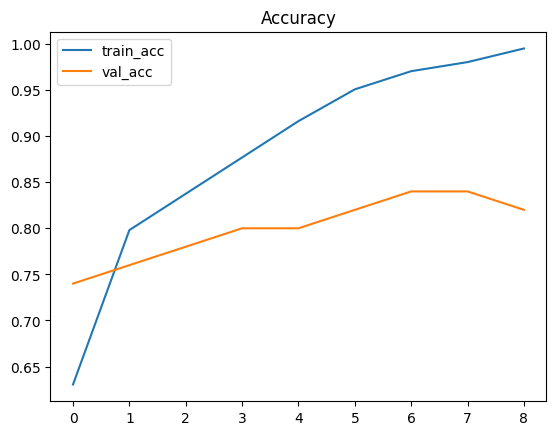

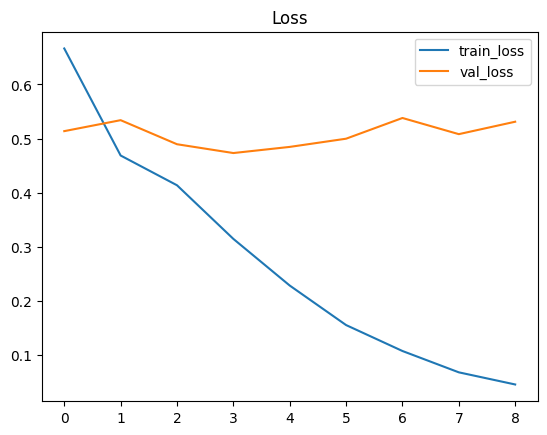

              precision    recall  f1-score   support

          no       0.82      0.53      0.64        17
         yes       0.79      0.94      0.86        33

    accuracy                           0.80        50
   macro avg       0.81      0.73      0.75        50
weighted avg       0.80      0.80      0.79        50



2025-08-14 18:52:49.735645: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


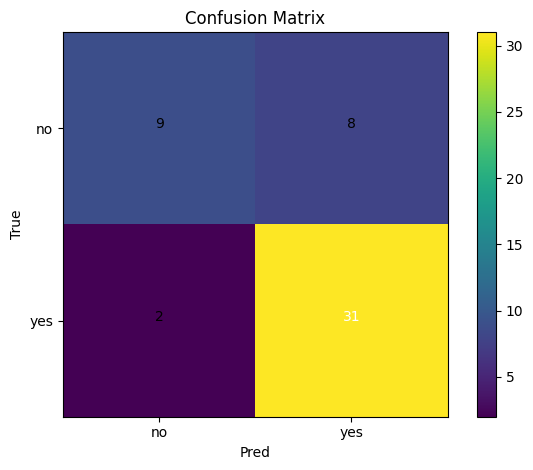

In [ ]:
# Plot training curves
plt.figure(); plt.plot(history.history["accuracy"], label="train_acc"); plt.plot(history.history["val_accuracy"], label="val_acc"); plt.legend(); plt.title("Accuracy"); plt.show()
plt.figure(); plt.plot(history.history["loss"], label="train_loss"); plt.plot(history.history["val_loss"], label="val_loss"); plt.legend(); plt.title("Loss"); plt.show()

# Confusion matrix on validation
y_true, y_pred = [], []
for xb, yb in val_ds:
    p = (model.predict(xb, verbose=0).ravel() > 0.5).astype(int)
    y_pred.extend(p.tolist())
    y_true.extend(yb.numpy().ravel().astype(int).tolist())

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest'); plt.title("Confusion Matrix"); plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names); plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True'); plt.xlabel('Pred'); plt.tight_layout(); plt.show()


In [ ]:
os.makedirs("models", exist_ok=True)
MODEL_PATH = "models/brain_tumor_model.keras"  # native Keras format
model.save(MODEL_PATH)
print("Saved:", MODEL_PATH)


Saved: models/brain_tumor_model.keras


/var/folders/mx/zjf1bvsx7rvdsqczwdc6dw440000gn/T/ipykernel_2536/524294413.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(yb[idx].numpy())
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=['Tensor(shape=(1, 150, 150, 1))']
  warnings.warn(msg)


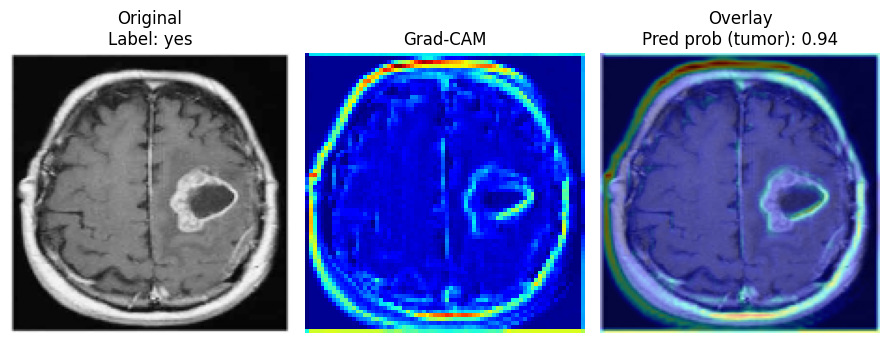

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def get_gradcam_heatmap(model, img_tensor, last_conv_layer_name="conv2"):
    # Ensure the model is built (call once)
    _ = model(img_tensor, training=False)

    conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_tensor, training=False)
        # For binary outputs, target the tumor probability (index 0)
        loss = preds[:, 0]

    grads = tape.gradient(loss, conv_out)                               # (1,H,W,C)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))                # (C,)
    conv_out = conv_out[0]                                              # (H,W,C)

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_out), axis=-1)
    heatmap = tf.maximum(heatmap, 0)                                    # ReLU
    max_val = tf.reduce_max(heatmap) + 1e-8
    heatmap = heatmap / max_val
    return heatmap.numpy()                                              # (H,W)

# Grab one batch from val_ds
for xb, yb in val_ds.take(1):
    # pick an index to visualize
    idx = 0
    img = xb[idx:idx+1]  # shape (1,150,150,1)
    label = int(yb[idx].numpy())
    prob = float(model.predict(img, verbose=0)[0][0])
    heatmap = get_gradcam_heatmap(model, img, "conv2")

    # Plot original (grayscale) + heatmap overlay
    h = (heatmap * 255).astype("uint8")
    h = tf.image.resize(tf.expand_dims(h, -1), IMG_SIZE).numpy().squeeze()  # (150,150)

    plt.figure(figsize=(9,4))
    plt.subplot(1,3,1); plt.imshow(img[0].numpy().squeeze(), cmap="gray"); plt.title(f"Original\nLabel: {class_names[label]}"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); 
    plt.imshow(img[0].numpy().squeeze(), cmap="gray")
    plt.imshow(h, cmap="jet", alpha=0.4); 
    plt.title(f"Overlay\nPred prob (tumor): {prob:.2f}")
    plt.axis("off")
    plt.tight_layout(); plt.show()
    break


Prediction: yes (tumor) | tumor probability = 0.965


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 150, 150, 1))
  warnings.warn(msg)


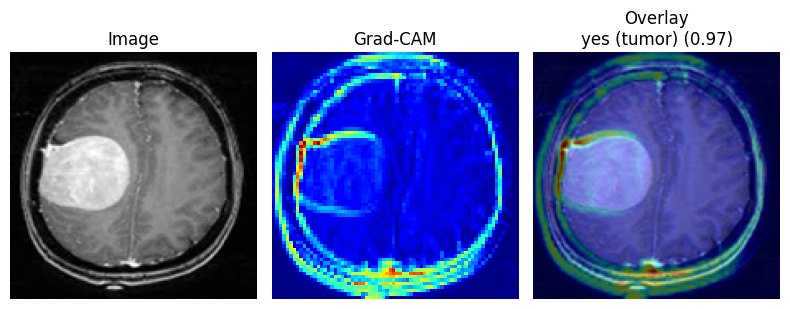

In [ ]:
from PIL import Image

IMG_PATH = "/Users/poojan/brain_tumor_project/dataset/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg" 

img = Image.open(IMG_PATH).convert("L").resize(IMG_SIZE)
arr = np.array(img, dtype=np.float32)/255.0
arr = arr[None, ..., None]  # (1,150,150,1)

prob = float(model.predict(arr, verbose=0)[0][0])
pred = "yes (tumor)" if prob >= 0.5 else "no (no tumor)"
print(f"Prediction: {pred} | tumor probability = {prob:.3f}")

# Grad-CAM for this image too (optional)
heatmap = get_gradcam_heatmap(model, arr, "conv2")
plt.figure(figsize=(8,3))
plt.subplot(1,3,1); plt.imshow(arr[0].squeeze(), cmap="gray"); plt.title("Image"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
plt.subplot(1,3,3); 
overlay = tf.image.resize(tf.expand_dims(heatmap, -1), IMG_SIZE).numpy().squeeze()
plt.imshow(arr[0].squeeze(), cmap="gray"); plt.imshow(overlay, cmap="jet", alpha=0.4)
plt.title(f"Overlay\n{pred} ({prob:.2f})"); plt.axis("off")
plt.tight_layout(); plt.show()
